Importación de Librerias

In [ ]:
"""
RANDOM FOREST PARA CLASIFICACIÓN DE ENFERMEDADES DE CEBOLLA
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

#Librerias para guardar archivos
import joblib
from pathlib import Path
out_dir = Path.cwd() / "Random_Forest" #Carpeta para guardar y cargar los modelos de Random Forest
out_dir.mkdir(parents=True, exist_ok=True)

Función para cargar los archivos desde CSV

In [3]:
def cargar_datos_desde_csv(csv_path='onion_dataset.csv', tamano_imagen=(32, 32)):
    """
    Carga las imágenes desde el CSV y las convierte a vectores de características.
    """
    
    print("="*60)
    print("CARGANDO DATASET")
    print("="*60)
    
    df = pd.read_csv(csv_path)
    print(f"Archivo CSV cargado: {len(df)} imágenes encontradas")
    
    clases_unicas = df['class'].unique()
    print(f"Clases encontradas: {len(clases_unicas)}")
    for i, clase in enumerate(clases_unicas, 1):
        print(f"   {i}. {clase}")
    
    X = []
    y = []
    errores = 0
    
    print(f"\nProcesando imágenes (tamaño: {tamano_imagen})...")
    
    for idx, fila in df.iterrows():
        try:
            imagen = Image.open(fila['image_path'])
            
            if imagen.mode != 'RGB':
                imagen = imagen.convert('RGB')
            
            imagen = imagen.resize(tamano_imagen)
            imagen_array = np.array(imagen).flatten()
            imagen_normalizada = imagen_array / 255.0
            
            X.append(imagen_normalizada)
            y.append(fila['class'])
            
            if (idx + 1) % 100 == 0:
                print(f"   Procesadas: {idx + 1}/{len(df)}")
                
        except Exception as e:
            errores += 1
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"\nProcesamiento completado")
    print(f"   Imágenes procesadas: {len(X)}")
    print(f"   Errores: {errores}")
    print(f"   Forma de X: {X.shape}")
    print(f"   Número de características: {X.shape[1]}")
    
    return X, y, clases_unicas

Función para optimizar los hiperparametros

In [4]:
def optimizar_hiperparametros(X_train, y_train, busqueda_rapida=True):
    """
    Encuentra los mejores hiperparámetros usando GridSearchCV.
    """
    
    print("\n" + "="*60)
    print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
    print("="*60)
    
    if busqueda_rapida:
        # Búsqueda rápida con menos combinaciones
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        cv_folds = 3
    else:
        # Búsqueda exhaustiva
        param_grid = {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
        cv_folds = 5
    
    print("Parámetros a evaluar:")
    for param, valores in param_grid.items():
        print(f"   {param}: {valores}")
    
    # Crear modelo base
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    # Búsqueda de hiperparámetros
    print(f"\nRealizando búsqueda con {cv_folds}-fold cross validation...")
    grid_search = GridSearchCV(
        rf, 
        param_grid, 
        cv=cv_folds, 
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\nMejores parámetros encontrados:")
    for param, valor in grid_search.best_params_.items():
        print(f"   {param}: {valor}")
    
    print(f"\nMejor score de validación: {grid_search.best_score_:.4f}")
    
    return grid_search.best_params_

Función para Entrenar Modelo

In [5]:
def entrenar_random_forest(X_train, y_train, **params):
    """
    Entrena un modelo Random Forest.
    """
    
    print("\n" + "="*60)
    print("ENTRENANDO RANDOM FOREST")
    print("="*60)
    
    # Parámetros por defecto si no se proporcionan
    default_params = {
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': 0
    }
    
    # Actualizar con parámetros proporcionados
    default_params.update(params)
    
    modelo = RandomForestClassifier(**default_params)
    
    print("Configuración del modelo:")
    print(f"   Número de árboles: {default_params['n_estimators']}")
    print(f"   Profundidad máxima: {default_params['max_depth']}")
    print(f"   Min muestras para dividir: {default_params['min_samples_split']}")
    print(f"   Min muestras en hoja: {default_params['min_samples_leaf']}")
    print(f"   Max características: {default_params['max_features']}")
    
    print("\nEntrenando modelo...")
    modelo.fit(X_train, y_train)
    
    print("Modelo entrenado exitosamente")
    print(f"   Número de características: {modelo.n_features_in_}")
    print(f"   Número de clases: {modelo.n_classes_}")
    
    return modelo

Función para evaluar el modelo

In [6]:
def evaluar_modelo(modelo, X_test, y_test, nombres_clases):
    """
    Evalúa el modelo y muestra métricas.
    """
    
    print("\n" + "="*60)
    print("EVALUACIÓN DEL MODELO RANDOM FOREST")
    print("="*60)
    
    # Hacer predicciones
    y_pred = modelo.predict(X_test)
    
    # Calcular accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nACCURACY GENERAL: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Score OOB si está disponible
    if hasattr(modelo, 'oob_score_') and modelo.oob_score_:
        print(f"OOB Score: {modelo.oob_score_:.4f}")
    
    # Reporte de clasificación
    print("\nREPORTE DETALLADO POR CLASE:")
    print("-"*60)
    reporte = classification_report(y_test, y_pred, target_names=nombres_clases, zero_division=0)
    print(reporte)
    
    # Calcular matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)
    
    return accuracy, y_pred, matriz_confusion

Evaluar Caracteristícas Importantes

In [20]:
def analizar_importancia_caracteristicas(modelo, n_top=20):
    """
    Analiza y visualiza la importancia de las características.
    """
    
    print("\n" + "="*60)
    print("IMPORTANCIA DE CARACTERÍSTICAS")
    print("="*60)
    
    # Obtener importancias
    importancias = modelo.feature_importances_
    indices = np.argsort(importancias)[::-1]
    
    # Mostrar las más importantes
    print(f"\nTop {n_top} características más importantes:")
    for i in range(min(n_top, len(importancias))):
        print(f"   {i+1}. Característica {indices[i]}: {importancias[indices[i]]:.6f}")
    
    # Visualizar
    plt.figure(figsize=(12, 6))
    
    # Gráfico de barras para top características
    plt.subplot(1, 2, 1)
    top_indices = indices[:n_top]
    plt.bar(range(n_top), importancias[top_indices])
    plt.xlabel('Índice de Característica')
    plt.ylabel('Importancia')
    plt.title(f'Top {n_top} Características Más Importantes')
    plt.xticks(range(n_top), top_indices, rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Distribución de importancias
    plt.subplot(1, 2, 2)
    plt.hist(importancias, bins=50, edgecolor='black')
    plt.xlabel('Importancia')
    plt.ylabel('Número de Características')
    plt.title('Distribución de Importancia de Características')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(out_dir/'importancia_caracteristicas_rf.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Calcular importancia acumulada
    importancias_ordenadas = importancias[indices]
    importancia_acumulada = np.cumsum(importancias_ordenadas)
    
    # Encontrar cuántas características representan el 90% de importancia
    n_90 = np.where(importancia_acumulada >= 0.9)[0][0] + 1 if np.any(importancia_acumulada >= 0.9) else len(importancias)
    print(f"\nCaracterísticas necesarias para 90% de importancia: {n_90}")
    print(f"Porcentaje del total: {n_90/len(importancias)*100:.1f}%")

Función para visualizar la matriz de confusión

In [19]:
def visualizar_matriz_confusion(matriz_confusion, nombres_clases):
    """
    Visualiza la matriz de confusión.
    """
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(matriz_confusion, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=nombres_clases,
                yticklabels=nombres_clases,
                cbar=True)
    plt.title('Matriz de Confusión - Random Forest', fontsize=14)
    plt.ylabel('Clase Real', fontsize=12)
    plt.xlabel('Clase Predicha', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.savefig(out_dir/'matriz_confusion_rf.png', dpi=100, bbox_inches='tight')
    plt.show()

Función para analizar el rendimiento de los arboles

In [18]:
def analizar_arboles(modelo, X_test, y_test, n_arboles_analizar=5):
    """
    Analiza el rendimiento de árboles individuales.
    """
    
    print("\n" + "="*60)
    print("ANÁLISIS DE ÁRBOLES INDIVIDUALES")
    print("="*60)
    
    accuracies_arboles = []
    
    print(f"\nEvaluando primeros {n_arboles_analizar} árboles...")
    
    for i in range(min(n_arboles_analizar, len(modelo.estimators_))):
        arbol = modelo.estimators_[i]
        y_pred_arbol = arbol.predict(X_test)
        acc_arbol = accuracy_score(y_test, y_pred_arbol)
        accuracies_arboles.append(acc_arbol)
        print(f"   Árbol {i+1}: Accuracy = {acc_arbol:.4f}")
    
    # Evaluar todos los árboles
    print("\nEvaluando todos los árboles...")
    todas_accuracies = []
    for arbol in modelo.estimators_:
        y_pred_arbol = arbol.predict(X_test)
        acc_arbol = accuracy_score(y_test, y_pred_arbol)
        todas_accuracies.append(acc_arbol)
    
    print(f"\nEstadísticas de árboles individuales:")
    print(f"   Accuracy promedio: {np.mean(todas_accuracies):.4f}")
    print(f"   Accuracy std: {np.std(todas_accuracies):.4f}")
    print(f"   Accuracy mínimo: {np.min(todas_accuracies):.4f}")
    print(f"   Accuracy máximo: {np.max(todas_accuracies):.4f}")
    
    # Visualizar distribución
    plt.figure(figsize=(10, 6))
    plt.hist(todas_accuracies, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(todas_accuracies), color='red', linestyle='--', label='Promedio')
    plt.xlabel('Accuracy')
    plt.ylabel('Número de Árboles')
    plt.title('Distribución de Accuracy de Árboles Individuales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(out_dir/'distribucion_arboles_rf.png', dpi=100, bbox_inches='tight')
    plt.show()

Función para analizar la convergencia

In [17]:
def analizar_convergencia(modelo, X_test, y_test):
    """
    Analiza cómo mejora el rendimiento al agregar más árboles.
    """
    
    print("\n" + "="*60)
    print("ANÁLISIS DE CONVERGENCIA")
    print("="*60)
    
    n_arboles = len(modelo.estimators_)
    accuracies_acumulados = []
    
    # Calcular accuracy con número creciente de árboles
    for n in range(1, min(n_arboles + 1, 101), 5):  # Evaluar cada 5 árboles
        # Hacer predicción con subset de árboles
        predicciones = np.zeros((len(X_test), modelo.n_classes_))
        for i in range(n):
            pred_proba = modelo.estimators_[i].predict_proba(X_test)
            predicciones += pred_proba
        
        y_pred_subset = np.argmax(predicciones, axis=1)
        acc = accuracy_score(y_test, y_pred_subset)
        accuracies_acumulados.append(acc)
    
    # Graficar
    x_valores = list(range(1, min(n_arboles + 1, 101), 5))
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_valores, accuracies_acumulados, 'b-', linewidth=2)
    plt.xlabel('Número de Árboles')
    plt.ylabel('Accuracy')
    plt.title('Convergencia del Random Forest')
    plt.grid(True, alpha=0.3)
    plt.savefig(out_dir/'convergencia_rf.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"\nAccuracy con 1 árbol: {accuracies_acumulados[0]:.4f}")
    print(f"Accuracy con {x_valores[-1]} árboles: {accuracies_acumulados[-1]:.4f}")
    print(f"Mejora total: {(accuracies_acumulados[-1] - accuracies_acumulados[0]):.4f}")

Función para predecir nueva imagen

In [2]:
def predecir_imagen(ruta_imagen, modelo_path=out_dir/'modelo_random_forest.pkl'):
    """
    Predice la clase de una nueva imagen usando el modelo Random Forest entrenado
    y muestra la imagen junto con su clasificación predicha.
    """
    import joblib
    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt

    try:
        # Cargar modelo y transformadores
        modelo = joblib.load(modelo_path)
        label_encoder = joblib.load(out_dir/'label_encoder_rf.pkl')
        
        # Cargar imagen original (para mostrarla en buena calidad)
        imagen_original = Image.open(ruta_imagen)

        # Procesar imagen para el modelo
        imagen = imagen_original
        if imagen.mode != 'RGB':
            imagen = imagen.convert('RGB')
        imagen = imagen.resize((32, 32))
        imagen_array = np.array(imagen).flatten() / 255.0
        imagen_array = imagen_array.reshape(1, -1)
        
        # Predecir
        prediccion = modelo.predict(imagen_array)[0]
        probabilidades = modelo.predict_proba(imagen_array)[0]
        
        # Decodificar
        clase_predicha = label_encoder.inverse_transform([prediccion])[0]
        confianza = max(probabilidades)

        print(f"\nPREDICCIÓN:")
        print(f"   Clase: {clase_predicha}")
        print(f"   Confianza: {confianza:.2%}")
        
        # Mostrar top 3 predicciones
        indices_top = np.argsort(probabilidades)[::-1][:3]
        print(f"\nTop 3 predicciones:")
        for i, idx in enumerate(indices_top):
            clase = label_encoder.inverse_transform([idx])[0]
            prob = probabilidades[idx]
            print(f"   {i+1}. {clase}: {prob:.2%}")

        # Mostrar imagen con la predicción como título
        plt.figure()
        plt.imshow(imagen_original)
        plt.axis('off')
        plt.title(f'Predicción: {clase_predicha} ({confianza:.2%})')
        plt.show()
        
        return clase_predicha
    
    except Exception as e:
        print(f"Error al predecir la imagen: {e}")
        return None

Definición de Parametros para modelo

In [11]:
CSV_PATH = 'onion_dataset.csv'
TAMANO_IMAGEN = (32, 32)
TEST_SIZE = 0.2
OPTIMIZAR_PARAMS = True  # Cambiar a False para usar parámetros por defecto

In [12]:
# 1. Cargar datos
X, y, clases_unicas = cargar_datos_desde_csv(CSV_PATH, TAMANO_IMAGEN)

CARGANDO DATASET
Archivo CSV cargado: 13229 imágenes encontradas
Clases encontradas: 15
   1. Alternaria_D
   2. Botrytis Leaf Blight
   3. Bulb Rot
   4. Bulb_blight-D
   5. Caterpillar-P
   6. Downy mildew
   7. Fusarium-D
   8. Healthy leaves
   9. Iris yellow virus_augment
   10. Purple blotch
   11. Rust
   12. Virosis-D
   13. Xanthomonas Leaf Blight
   14. onion1
   15. stemphylium Leaf Blight

Procesando imágenes (tamaño: (32, 32))...
   Procesadas: 100/13229
   Procesadas: 200/13229
   Procesadas: 300/13229
   Procesadas: 400/13229
   Procesadas: 500/13229
   Procesadas: 600/13229
   Procesadas: 700/13229
   Procesadas: 800/13229
   Procesadas: 900/13229
   Procesadas: 1000/13229
   Procesadas: 1100/13229
   Procesadas: 1200/13229
   Procesadas: 1300/13229
   Procesadas: 1400/13229
   Procesadas: 1500/13229
   Procesadas: 1600/13229
   Procesadas: 1700/13229
   Procesadas: 1800/13229
   Procesadas: 1900/13229
   Procesadas: 2000/13229
   Procesadas: 2100/13229
   Procesadas: 2

In [13]:
# 2. Codificar etiquetas
print("\nCodificando etiquetas...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Mapeo de clases a números:")
for i, clase in enumerate(label_encoder.classes_):
    print(f"   {i}: {clase}")


Codificando etiquetas...
Mapeo de clases a números:
   0: Alternaria_D
   1: Botrytis Leaf Blight
   2: Bulb Rot
   3: Bulb_blight-D
   4: Caterpillar-P
   5: Downy mildew
   6: Fusarium-D
   7: Healthy leaves
   8: Iris yellow virus_augment
   9: Purple blotch
   10: Rust
   11: Virosis-D
   12: Xanthomonas Leaf Blight
   13: onion1
   14: stemphylium Leaf Blight


In [14]:
# 3. Dividir en entrenamiento y prueba
print("\nDividiendo datos...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=42,
    stratify=y_encoded
)
print(f"   Entrenamiento: {len(X_train)} imágenes")
print(f"   Prueba: {len(X_test)} imágenes")


Dividiendo datos...
   Entrenamiento: 10583 imágenes
   Prueba: 2646 imágenes


In [15]:
# 4. Optimizar hiperparámetros
mejores_params = optimizar_hiperparametros(X_train, y_train, busqueda_rapida=True)


OPTIMIZACIÓN DE HIPERPARÁMETROS
Parámetros a evaluar:
   n_estimators: [50, 100, 200]
   max_depth: [10, 20, None]
   min_samples_split: [2, 5]
   min_samples_leaf: [1, 2]

Realizando búsqueda con 3-fold cross validation...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Mejores parámetros encontrados:
   max_depth: None
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 200

Mejor score de validación: 0.6214


In [21]:
# 5. Entrenar modelo
modelo = entrenar_random_forest(X_train, y_train, **mejores_params)


ENTRENANDO RANDOM FOREST
Configuración del modelo:
   Número de árboles: 200
   Profundidad máxima: None
   Min muestras para dividir: 2
   Min muestras en hoja: 1
   Max características: sqrt

Entrenando modelo...
Modelo entrenado exitosamente
   Número de características: 3072
   Número de clases: 15


In [22]:
# 6. Evaluar modelo
accuracy, y_pred, matriz = evaluar_modelo(
    modelo, 
    X_test, 
    y_test,
    label_encoder.classes_
)


EVALUACIÓN DEL MODELO RANDOM FOREST

ACCURACY GENERAL: 0.6795 (67.95%)

REPORTE DETALLADO POR CLASE:
------------------------------------------------------------
                           precision    recall  f1-score   support

             Alternaria_D       0.96      0.58      0.72       166
     Botrytis Leaf Blight       0.47      0.60      0.53        58
                 Bulb Rot       0.00      0.00      0.00         1
            Bulb_blight-D       1.00      0.97      0.99        79
            Caterpillar-P       0.91      0.93      0.92       312
             Downy mildew       0.00      0.00      0.00         7
               Fusarium-D       0.92      0.71      0.81       255
           Healthy leaves       0.53      0.91      0.67       688
Iris yellow virus_augment       0.55      0.34      0.42       380
            Purple blotch       0.96      0.56      0.71       170
                     Rust       0.55      0.63      0.59        43
                Virosis-D       

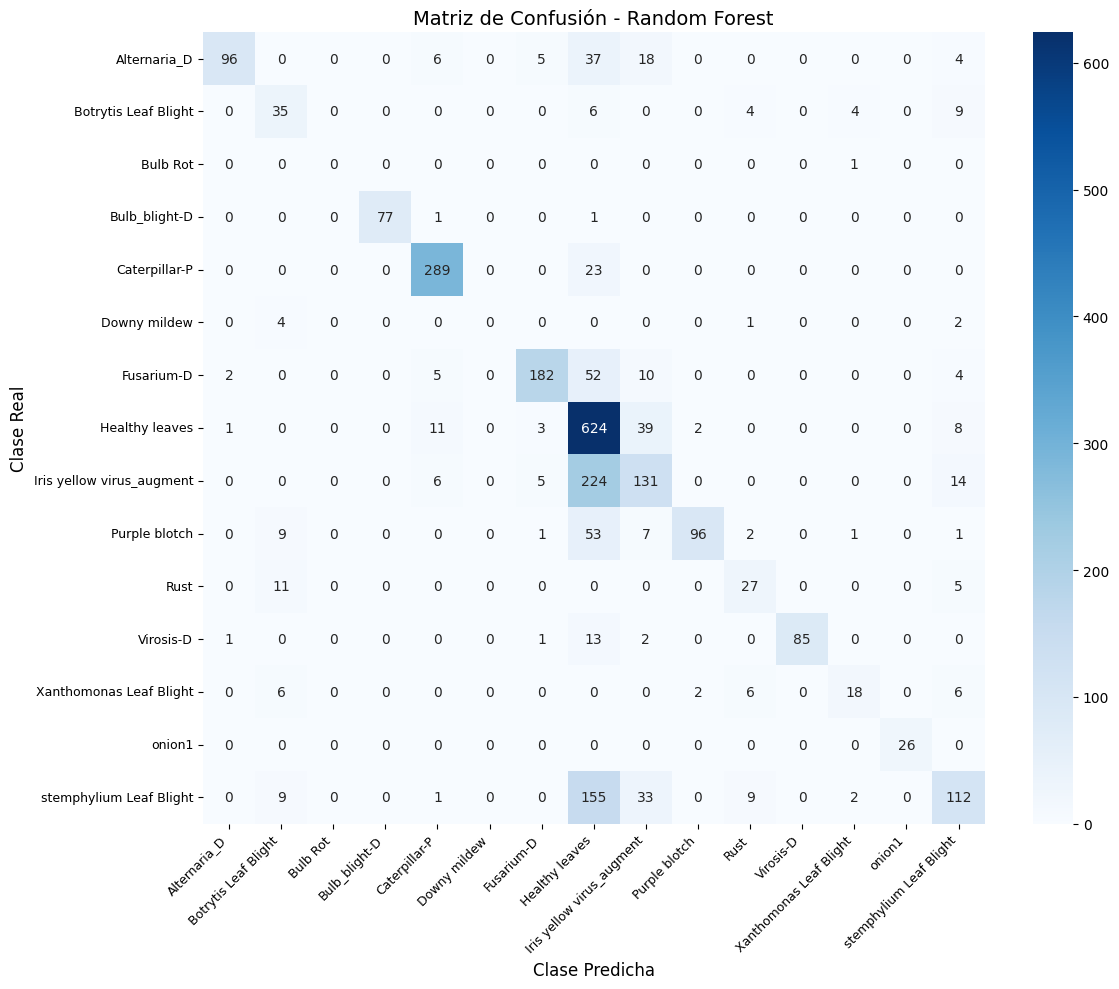

In [23]:
# 7. Visualizar matriz de confusión
visualizar_matriz_confusion(matriz, label_encoder.classes_)


IMPORTANCIA DE CARACTERÍSTICAS

Top 30 características más importantes:
   1. Característica 1485: 0.001332
   2. Característica 1677: 0.001238
   3. Característica 1389: 0.001186
   4. Característica 1482: 0.001172
   5. Característica 1575: 0.001166
   6. Característica 1674: 0.001144
   7. Característica 1773: 0.001124
   8. Característica 1581: 0.001113
   9. Característica 1680: 0.001086
   10. Característica 1776: 0.001049
   11. Característica 1578: 0.001035
   12. Característica 99: 0.001021
   13. Característica 1386: 0.001012
   14. Característica 236: 0.001007
   15. Característica 1584: 0.000999
   16. Característica 1488: 0.000979
   17. Característica 100: 0.000978
   18. Característica 2983: 0.000934
   19. Característica 1869: 0.000909
   20. Característica 1770: 0.000906
   21. Característica 1101: 0.000894
   22. Característica 1392: 0.000882
   23. Característica 909: 0.000852
   24. Característica 332: 0.000848
   25. Característica 2979: 0.000837
   26. Caracterís

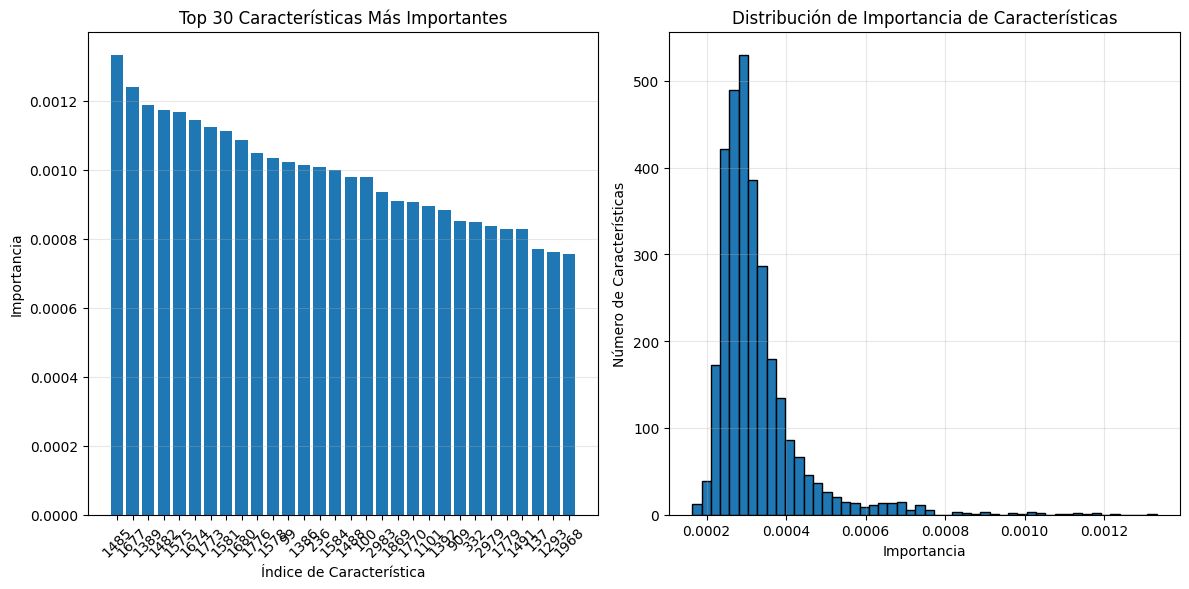


Características necesarias para 90% de importancia: 2636
Porcentaje del total: 85.8%


In [24]:
 # 8. Analizar importancia de características
analizar_importancia_caracteristicas(modelo, n_top=30)


ANÁLISIS DE ÁRBOLES INDIVIDUALES

Evaluando primeros 5 árboles...
   Árbol 1: Accuracy = 0.4369
   Árbol 2: Accuracy = 0.4543
   Árbol 3: Accuracy = 0.4475
   Árbol 4: Accuracy = 0.4596
   Árbol 5: Accuracy = 0.4611

Evaluando todos los árboles...

Estadísticas de árboles individuales:
   Accuracy promedio: 0.4541
   Accuracy std: 0.0092
   Accuracy mínimo: 0.4263
   Accuracy máximo: 0.4781


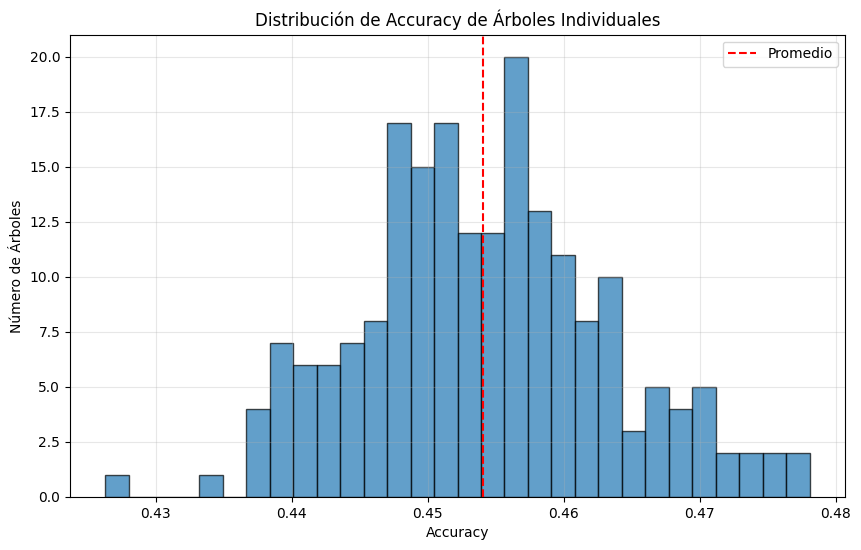

In [25]:
# 9. Analizar árboles individuales
analizar_arboles(modelo, X_test, y_test)


ANÁLISIS DE CONVERGENCIA


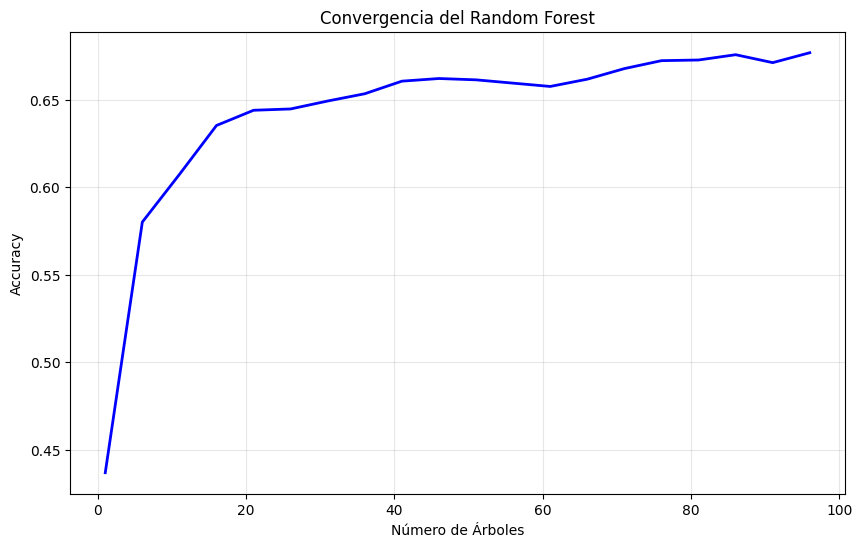


Accuracy con 1 árbol: 0.4369
Accuracy con 96 árboles: 0.6769
Mejora total: 0.2400


In [26]:
# 10. Analizar convergencia
analizar_convergencia(modelo, X_test, y_test)

In [28]:
# 11. Guardar modelo
joblib.dump(modelo, out_dir/'modelo_random_forest.pkl')
joblib.dump(label_encoder, out_dir/'label_encoder_rf.pkl')
print("\nModelo guardado como 'modelo_random_forest.pkl'")


Modelo guardado como 'modelo_random_forest.pkl'


In [31]:
# 12. Análisis por clase
print("\n" + "="*60)
print("ANÁLISIS DE RENDIMIENTO POR CLASE")
print("="*60)
accuracies_por_clase = matriz.diagonal() / (matriz.sum(axis=1) + 1e-10)
for i, clase in enumerate(label_encoder.classes_):
    acc_clase = accuracies_por_clase[i]
    total_clase = matriz.sum(axis=1)[i]
    correctas = matriz.diagonal()[i]
    print(f"{clase:30s}: {acc_clase:6.2%} accuracy ({correctas}/{total_clase} correctas)")


ANÁLISIS DE RENDIMIENTO POR CLASE
Alternaria_D                  : 57.83% accuracy (96/166 correctas)
Botrytis Leaf Blight          : 60.34% accuracy (35/58 correctas)
Bulb Rot                      :  0.00% accuracy (0/1 correctas)
Bulb_blight-D                 : 97.47% accuracy (77/79 correctas)
Caterpillar-P                 : 92.63% accuracy (289/312 correctas)
Downy mildew                  :  0.00% accuracy (0/7 correctas)
Fusarium-D                    : 71.37% accuracy (182/255 correctas)
Healthy leaves                : 90.70% accuracy (624/688 correctas)
Iris yellow virus_augment     : 34.47% accuracy (131/380 correctas)
Purple blotch                 : 56.47% accuracy (96/170 correctas)
Rust                          : 62.79% accuracy (27/43 correctas)
Virosis-D                     : 83.33% accuracy (85/102 correctas)
Xanthomonas Leaf Blight       : 47.37% accuracy (18/38 correctas)
onion1                        : 100.00% accuracy (26/26 correctas)
stemphylium Leaf Blight       : 3


PREDICCIÓN:
   Clase: Alternaria_D
   Confianza: 88.00%

Top 3 predicciones:
   1. Alternaria_D: 88.00%
   2. Iris yellow virus_augment: 3.00%
   3. Healthy leaves: 2.50%


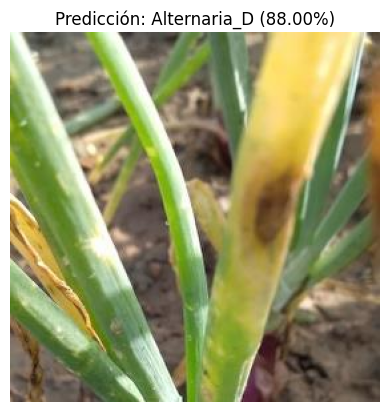

'Alternaria_D'

In [3]:
predecir_imagen("Imagenes_Prueba/Alternaria.jpg")


PREDICCIÓN:
   Clase: Botrytis Leaf Blight
   Confianza: 34.00%

Top 3 predicciones:
   1. Botrytis Leaf Blight: 34.00%
   2. Rust: 21.00%
   3. stemphylium Leaf Blight: 18.00%


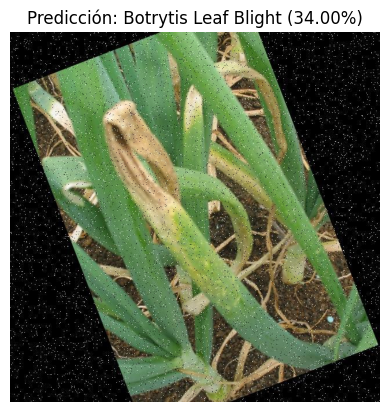

'Botrytis Leaf Blight'

In [4]:
predecir_imagen("Imagenes_Prueba/Downy.jpg")


PREDICCIÓN:
   Clase: Iris yellow virus_augment
   Confianza: 64.00%

Top 3 predicciones:
   1. Iris yellow virus_augment: 64.00%
   2. Healthy leaves: 12.50%
   3. Caterpillar-P: 7.50%


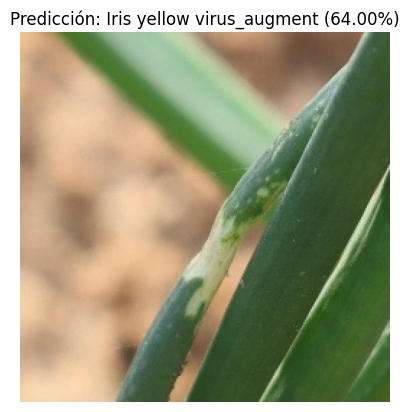

'Iris yellow virus_augment'

In [5]:
predecir_imagen("Imagenes_Prueba/Iris.jpg")


PREDICCIÓN:
   Clase: Purple blotch
   Confianza: 63.50%

Top 3 predicciones:
   1. Purple blotch: 63.50%
   2. Healthy leaves: 15.50%
   3. Iris yellow virus_augment: 7.50%


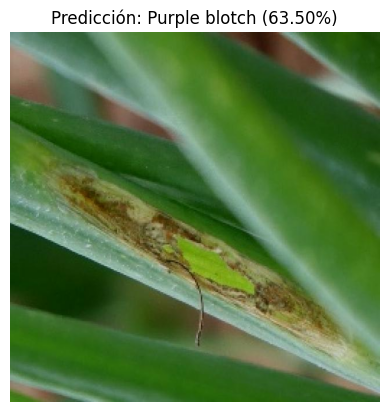

'Purple blotch'

In [6]:
predecir_imagen("Imagenes_Prueba/Purple.jpg")